# Optimasi Kekuatan Tekan Beton: Studi Komparatif Model Regresi untuk Efisiensi Bisnis di Industri Konstruksi

Pengerjaan|Nama
---|---
Kode |Muhammad Naufal Faza
Dokumentasi|Michael Harditya

## Inisiasi Library

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.pipeline import Pipeline
import seaborn as sns

## Visualisasi dan Analisis Awal

Bagian ini akan melakukan visualisasi dan analisis awal terhadap data. Pada bagian pertama menunjukan statistik deskriptif setiap variabel dalam dataset, termasuk `mean`, `std`, `min`, `50%`, dan `max`. Bagian berikutnya menunjukan beberapa grafik:
- Scatterplot tiap variabel dengan variabel target `Strength`, menunjukan bahwa data memiliki persebaran yang cukup besar, dan beberapa variabel tidak menunjukan hubungan linear (sebagai contoh adalah `Age` menunjukan kurva).
- Correlation Heatmap, memetakan korelasi antar variabel yang ada, dan menunjukan bahwa korelasi antar variabel cukup lemah.
- Histogram, memberikan visualisasi dari tiap variabel, terlihat beberapa variabel tidak memiliki distribusi normal.
- Boxplot, menunjukan persebaran serta *outlier* dari tiap variabel, terlihat perlu adanya regularisasi karena variabel memiliki skala yang berbeda.

            cement         slag          ash        water  superplastic  \
count  1030.000000  1030.000000  1030.000000  1030.000000   1030.000000   
mean    281.167864    73.895825    54.188350   181.567282      6.204660   
std     104.506364    86.279342    63.997004    21.354219      5.973841   
min     102.000000     0.000000     0.000000   121.800000      0.000000   
25%     192.375000     0.000000     0.000000   164.900000      0.000000   
50%     272.900000    22.000000     0.000000   185.000000      6.400000   
75%     350.000000   142.950000   118.300000   192.000000     10.200000   
max     540.000000   359.400000   200.100000   247.000000     32.200000   

         coarseagg      fineagg          age     strength  
count  1030.000000  1030.000000  1030.000000  1030.000000  
mean    972.918932   773.580485    45.662136    35.817961  
std      77.753954    80.175980    63.169912    16.705742  
min     801.000000   594.000000     1.000000     2.330000  
25%     932.000000   730

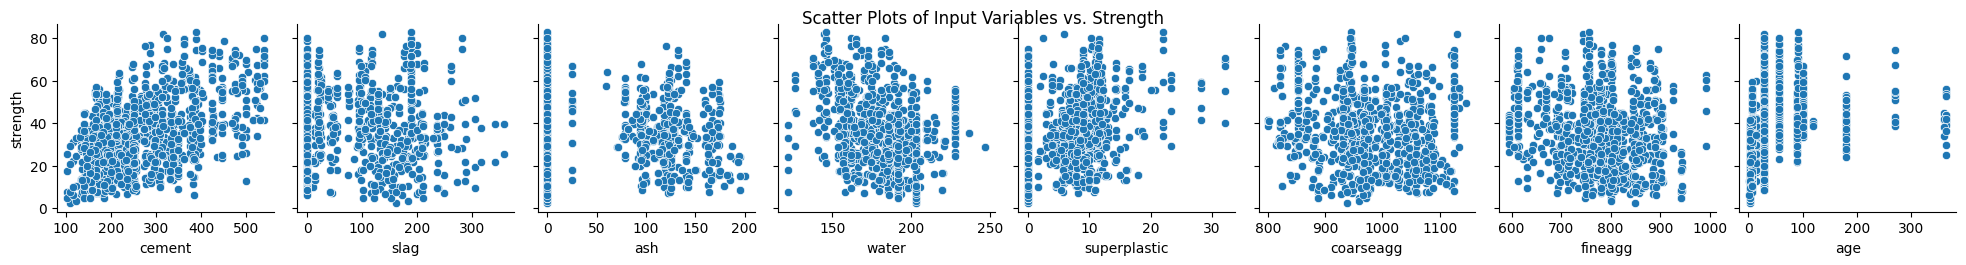

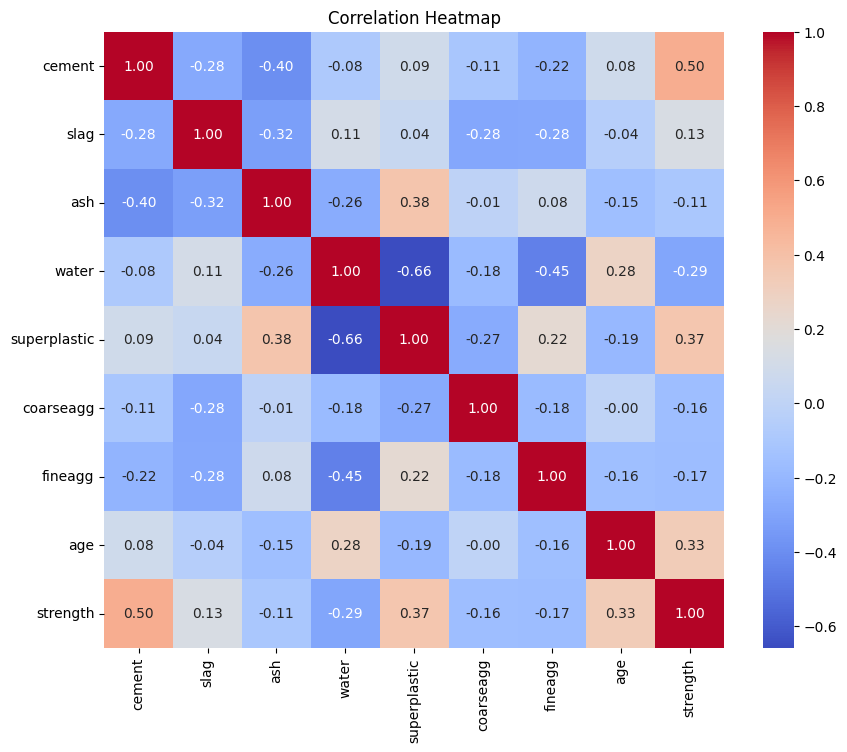

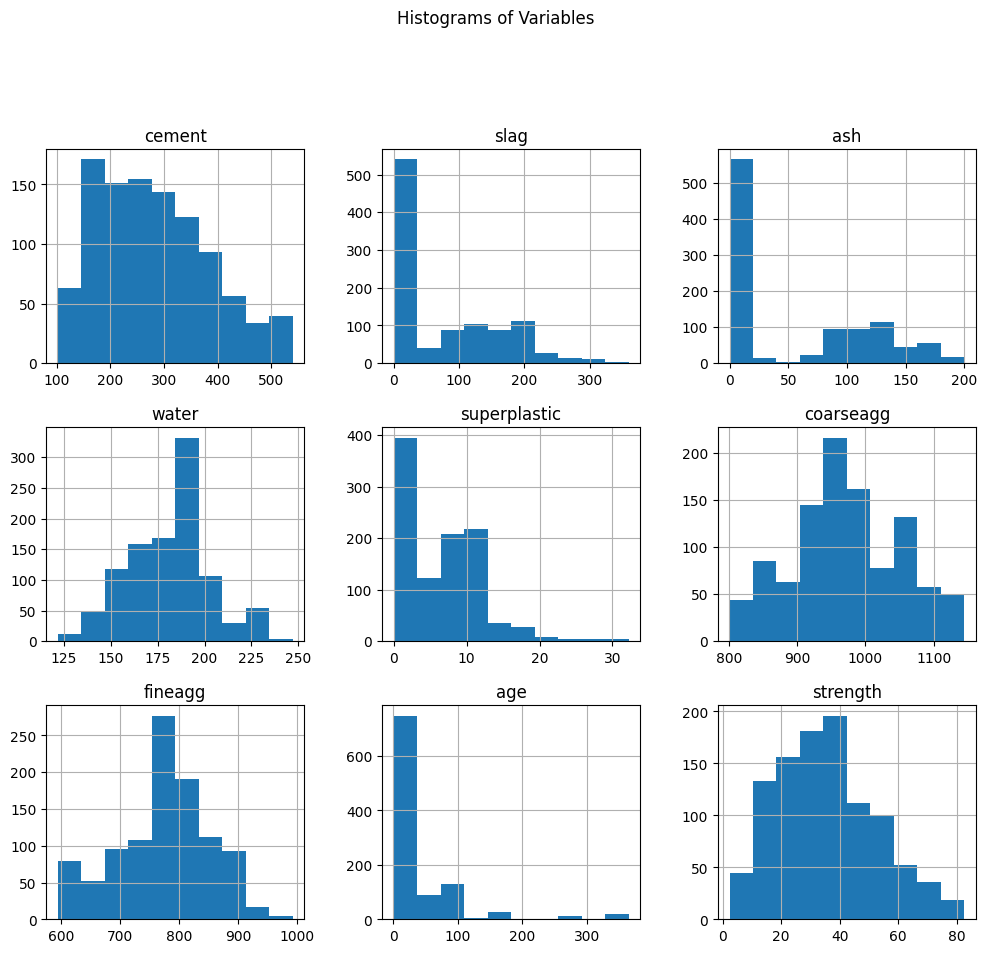

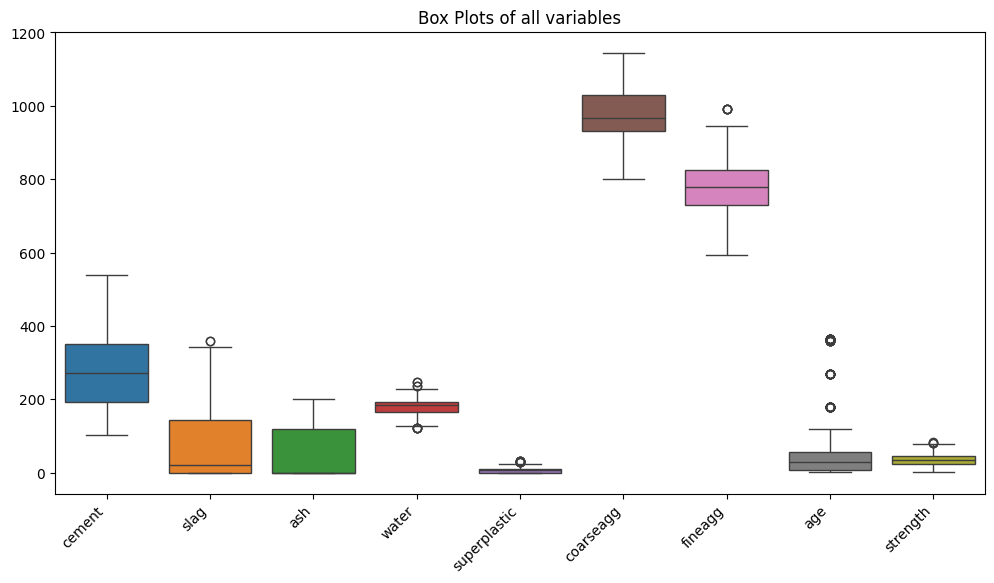

In [49]:
# Load dataset
df = pd.read_csv("data/concrete.csv")

# 1. Check dataset description
print(df.describe())

# Sebaran data setiap variabel input terhadap strength
sns.pairplot(df, x_vars=X.columns, y_vars='strength', kind='scatter', diag_kind=None)
plt.suptitle('Scatter Plots of Input Variables vs. Strength', y=1.02)
plt.show()


# Heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Distribusi data setiap variabel
df.hist(figsize=(12, 10))
plt.suptitle('Histograms of Variables', y=1.02)
plt.show()

# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title("Box Plots of all variables")
plt.show()

## Pemilihan Fitur
Pemilihan fitur yang akan digunakan pada percobaan dilakukan menggunakan *Recursive Feature Elimination* atau RFE. Metode RFE yang dilakukan menggunakan `XGBoost` sebagai *estimator*, yang kemudian digunakan untuk membuat nilai *feature importance* dari tiap fitur. Nilai-nilai ini kemudian digunakan oleh RFE untuk memutuskan fitur apa saja yang akan digunakan. Terdapat 7 dari 8 fitur yang terpilih yaitu `cement`, `slag`,`ash`,`water`,`superplastic`,`fineagg`, dan `age`. Fitur `coarseagg` tidak terpilih pada RFE.

In [32]:
# Features and Target
X = df.drop('strength', axis=1)
y = df['strength']

In [33]:
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Initialize the XGBRegressor model
xgb = XGBRegressor(random_state=42)

# Initialize variables to store the best results
min_rmse = float('inf')
best_num_features = 0
best_features = None
best_X_selected = None

# Iterate over different numbers of features to select the best one with the lowest RMSE
for n_features in range(1, X.shape[1] + 1):
    rfe = RFE(xgb, n_features_to_select=n_features)
    rfe.fit(X, y)
    
    X_rfe_selected = X.iloc[:, rfe.support_]
    X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe_selected, y, test_size=0.2, random_state=42)
    
    # Train XGBoost on the selected features
    xgb.fit(X_train_rfe, y_train_rfe)
    y_pred_rfe = xgb.predict(X_test_rfe)
    
    # Calculate RMSE
    rmse_rfe = np.sqrt(mean_squared_error(y_test_rfe, y_pred_rfe))
    
    # Track the best number of features
    if rmse_rfe < min_rmse:
        min_rmse = rmse_rfe
        best_num_features = n_features
        best_features = X.columns[rfe.support_]
        best_X_selected = X_rfe_selected

# Print the best number of features and the selected features
print(f"Best number of features: {best_num_features}")
print(f"Selected features based on RFE: {best_features}")

# Train the XGBoost model on the entire dataset with the best selected features
xgb.fit(best_X_selected, y)

# Get feature importances from XGBoost and create a DataFrame
feature_importances = xgb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': best_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance from XGBoost:\n", importance_df)

# Perform RFE for ranking all features (not just selected ones)
rfe = RFE(xgb, n_features_to_select=best_num_features)
rfe.fit(X, y)

# Create a DataFrame to display features and their rankings
ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
})

# Sort by ranking (1 means selected as most important)
ranking_df = ranking_df.sort_values(by='Ranking')

print("\nReal Feature Ranking (RFE):\n", ranking_df)

Best number of features: 7
Selected features based on RFE: Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'fineagg', 'age'], dtype='object')

Feature Importance from XGBoost:
         Feature  Importance
0        cement    0.232115
6           age    0.220302
4  superplastic    0.161129
1          slag    0.146283
3         water    0.128452
2           ash    0.055874
5       fineagg    0.055845

Real Feature Ranking (RFE):
         Feature  Ranking
0        cement        1
1          slag        1
2           ash        1
3         water        1
4  superplastic        1
6       fineagg        1
7           age        1
5     coarseagg        2


## Uji Asumsi untuk Linear Regression
Bagian ini merupakan bagian pengujian terhadap beberapa asumsi data yang digunakan pada metode Regresi Linear. Terdapat empat asumsi yang ada dan diujikan yaitu:
- **Linearitas**, dilakukan menggunakan visualisasi `scatterplot` yang dilakukan pada bagian-bagian sebelumnya, didapatkan tidak seluruh fitur memiliki sifat linear terhadap variabel target, **maka asumsi ini tidak terpenuhi**.
- **Residual terdistribusi normal**, pengujian dilakukan menggunakan tes Shapiro-Wilk, menghasilkan `p-value = 0.00635`, lebih kecil dari `0.05` menunjukan **residual tidak terdistribusi normal**.
- **Homoskedastisitas**, pengujian menggunakan tes Breusch-Pagan, menghasilkan `p-value = 5.80e_27`, menunjukan **adanya heteroskedastisitas pada data**.
- **Autokorelasi**, dilakukan menggunakan uji Durbin-Watson, menghasilkan nilai `1.866`, menunjukan **tidak ada autokorelasi yang signifikan**.
- **Tidak adanya multikolinearitas**, dilakukan menggunakan `VIF`, menghasilkan nilai rendah (dibawah `5`), menunjukan **Tidak ada multikolinearitas yang signifikan**.

Hasil pengujian menunjukan bahwa data tidak cocok untuk menggunakan metode Regresi Linear, dan model lainnya lebih cocok seperti Random Forest atau XGBoost yang akan diujikan pada bagian berikutnya.

In [54]:
# 3. Linear Regression Assumptions Test
# Add constant for statsmodels
X_selected_sm = sm.add_constant(best_X_selected)
lin_reg = sm.OLS(y, X_selected_sm).fit()

# Linear assumption (linear regression summary)
print(lin_reg.summary())

# Breusch-Pagan test for heteroscedasticity
_, bp_pvalue, _, _ = het_breuschpagan(lin_reg.resid, X_selected_sm)
print(f"Breusch-Pagan p-value: {bp_pvalue}")

# Durbin-Watson test for autocorrelation
dw = durbin_watson(lin_reg.resid)
print(f"Durbin-Watson: {dw}")

# Shapiro-Wilk test for normality of residuals
shapiro_test = shapiro(lin_reg.resid)
print(f"Shapiro-Wilk p-value: {shapiro_test.pvalue}")

# Check VIF for multicollinearity
vif = pd.DataFrame()
vif["VIF"] = [VIF(X_selected_sm.values, i) for i in range(X_selected_sm.shape[1])]
vif["Feature"] = X_selected_sm.columns
print(vif)

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     232.4
Date:                Sun, 06 Oct 2024   Prob (F-statistic):          2.51e-206
Time:                        15:35:48   Log-Likelihood:                -3870.8
No. Observations:                1030   AIC:                             7758.
Df Residuals:                    1022   BIC:                             7797.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           25.0701      8.673      2.891   

## Evaluasi Model dan Hyperparameter Tuning
Evaluasi dilakukan dengan melewati proses *hyperparameter tuning*, menggunakan metode `GridSearchCV` dengan *10-fold cross-validation* dari data *training*. Analisis lebih mendalam dapat diakses melalui paper.

In [36]:
# 4. Train-test split 80-20
X_train, X_test, y_train, y_test = train_test_split(best_X_selected, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models and hyperparameter grids for cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': Pipeline([
        ('poly', PolynomialFeatures()), 
        ('linear', LinearRegression())
    ]),  # Polynomial features will be added inside the pipeline
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}
# Hyperparameters for tuning
param_grids = {
    'Linear Regression': {},
    'Polynomial Regression': {'poly__degree': [2, 3, 4, 5]},  # This can be extended with PolynomialFeatures degree
    'SVR': {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]},
    'Random Forest': {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [None, 10, 20, 30]},
    'XGBoost': {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [3, 6, 10] }
}
best_models = {}
best_rmse = {}

In [44]:
# Initialize dictionary to store GridSearchCV objects for each model
grid_searches = {}# 10-fold cross-validation and hyperparameter tuning

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store the grid search results for each model
    grid_searches[model_name] = grid_search
    
    # Store the best model and its performance
    best_models[model_name] = grid_search.best_estimator_
    best_rmse[model_name] = np.sqrt(-grid_search.best_score_)
    print(f"Best RMSE for {model_name}: {best_rmse[model_name]}")

Training Linear Regression...
Best RMSE for Linear Regression: 10.47340632925883
Training Polynomial Regression...
Best RMSE for Polynomial Regression: 6.430815674752917
Training SVR...
Best RMSE for SVR: 7.065061885209335
Training Random Forest...
Best RMSE for Random Forest: 4.933612353834969
Training XGBoost...
Best RMSE for XGBoost: 4.3553747786251185


## Visualisasi Hasil Prediksi Model Terbaik
Model terbaik dari percobaan sebelumnya adalah `XGBoost`, dan pada bagian ini akan divisualisasikan performanya dengan metode Regresi Linear. terlihat bahwa `XGBoost` memiliki persebaran error yang lebih berdekatan dengan garis ideal.

                   Model       RMSE       MAE  \
0      Linear Regression  10.592858  8.445336   
1  Polynomial Regression   6.903015  4.940400   
2                    SVR   7.129341  4.892248   
3          Random Forest   5.183522  3.363342   
4                XGBoost   4.452929  2.784786   

                               Best Parameters  
0                                           {}  
1                          {'poly__degree': 3}  
2  {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}  
3       {'max_depth': 20, 'n_estimators': 400}  
4        {'max_depth': 3, 'n_estimators': 500}  


/tmp/ipykernel_1569099/1634143183.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


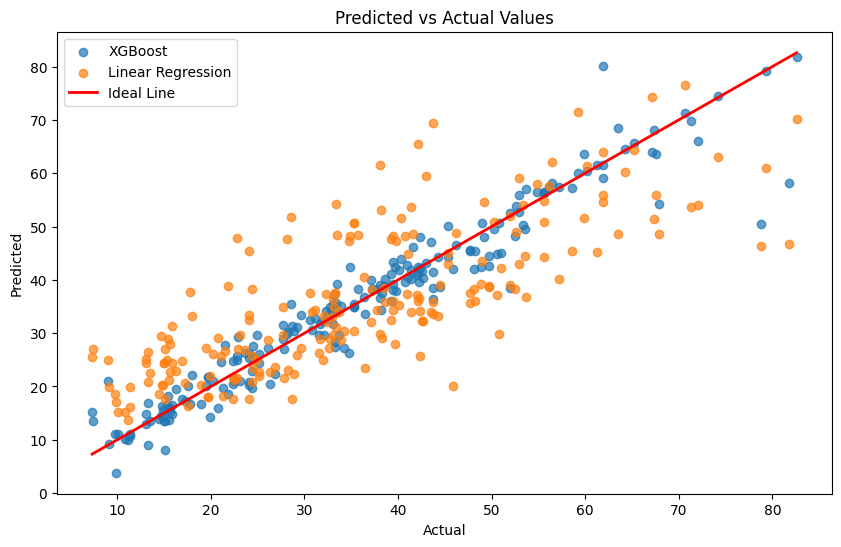

In [45]:
# 5. Comparing best models on the test set
results = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'Best Parameters'])

for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Access the best parameters from the respective GridSearchCV object
    best_params = grid_searches[model_name].best_params_
    
    # Add a new row with the model, RMSE, MAE, and best parameters
    new_row = pd.DataFrame({
        'Model': [model_name], 
        'RMSE': [rmse], 
        'MAE': [mae],
        'Best Parameters': [best_params]
    })
    
    results = pd.concat([results, new_row], ignore_index=True)

# Display comparison results
print(results)


# Visualizing predictions vs actual values
plt.figure(figsize=(10,6))
plt.scatter(y_test, best_models['XGBoost'].predict(X_test_scaled), label='XGBoost', alpha=0.7)
plt.scatter(y_test, best_models['Linear Regression'].predict(X_test_scaled), label='Linear Regression', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Predicted vs Actual Values')
plt.show()

## Analisis Sensitivitas
Untuk menambahkan insight, berikut adalah analisis faktor yang sangat mempengaruhi kekuatan tekan menggunakan *feature importance* pada model `XGBoost` serta *hyperparameter* terbaik yang didapatkan pada `GridSearchCV`.

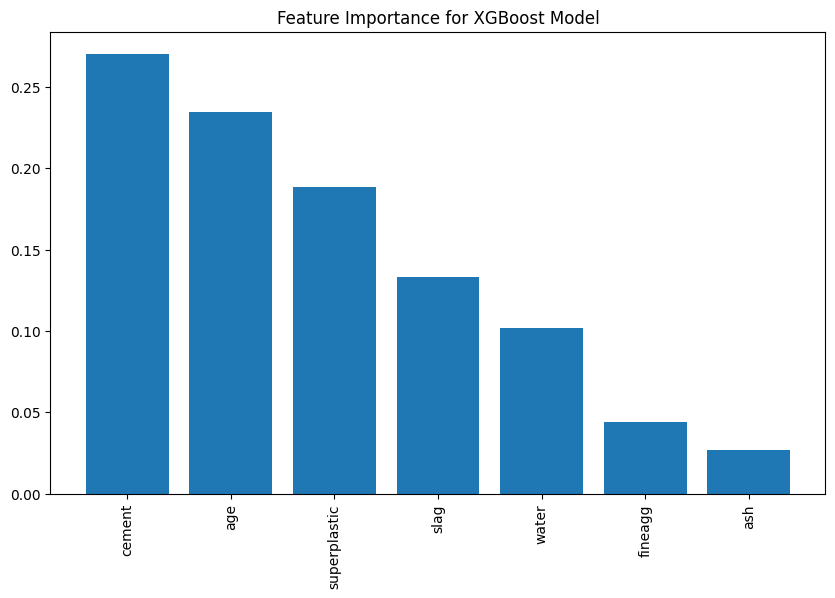

AttributeError: module 'pdpbox.info_plots' has no attribute 'pdp_isolate'

In [52]:
# 6. Sensitivity analysis (for XGBoost model)
xgb_model = best_models['XGBoost']
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title('Feature Importance for XGBoost Model')
plt.bar(range(best_X_selected.shape[1]), importances[indices], align='center')
plt.xticks(range(best_X_selected.shape[1]), best_X_selected.columns[indices], rotation=90)
plt.show()

from pdpbox import pdp, info_plots

# Partial Dependence Plot (PDP) untuk 'cement' (contoh)
pdp_cement = info_plots.pdp_isolate(model=xgb_model, dataset=pd.DataFrame(X_train_scaled, columns=best_X_selected.columns), model_features=best_X_selected.columns, feature='cement')
info_plots.pdp_plot(pdp_cement, 'cement')
plt.show()


# Individual Conditional Expectation (ICE) plots (contoh untuk cement)
pdp_ice_cement = info_plots.pdp_isolate(model=xgb_model, dataset=pd.DataFrame(X_train_scaled, columns=best_X_selected.columns),
                                model_features=best_X_selected.columns, feature='cement', num_grid_points=20, kind='individual')

info_plots.pdp_plot(pdp_ice_cement, 'cement', plot_lines=True, center=True, frac_to_plot=0.5, plot_pts_dist=True)
plt.show()

# ... (lakukan untuk fitur penting lainnya)